#### 5 year Forecasting With Online Sales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '1' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia
...,...,...,...,...
60393,2014-06-30,Online,21.9800,Canada
60394,2014-06-30,Online,8.9900,Canada
60395,2014-06-30,Online,21.9800,Canada
60396,2014-06-30,Online,159.0000,Canada


In [3]:
df.OrderDate.max() 

Timestamp('2014-06-30 00:00:00')

In [4]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [5]:
online_channel= df.loc[df['Region'] == 'Southwest',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
3,2011-05-31,Online,699.0982,Southwest
5,2011-06-01,Online,3578.2700,Southwest
9,2011-06-02,Online,3578.2700,Southwest
10,2011-06-02,Online,3578.2700,Southwest
16,2011-06-04,Online,3578.2700,Southwest
...,...,...,...,...
60359,2014-06-30,Online,21.9800,Southwest
60360,2014-06-30,Online,63.5000,Southwest
60361,2014-06-30,Online,21.9800,Southwest
60362,2014-06-30,Online,54.9900,Southwest


### Data Preprocessing

In [6]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [7]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,699.0982
1,2011-06-01,3578.2700
2,2011-06-02,7156.5400
3,2011-06-04,3578.2700
4,2011-06-05,3578.2700
...,...,...
912,2014-06-26,172.4900
913,2014-06-27,261.8200
914,2014-06-28,584.1100
915,2014-06-29,120.8400


### Indexing with Time Series Data

In [8]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-06-01', '2011-06-02', '2011-06-04',
               '2011-06-05', '2011-06-07', '2011-06-08', '2011-06-13',
               '2011-06-14', '2011-06-15',
               ...
               '2014-06-21', '2014-06-22', '2014-06-23', '2014-06-24',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='OrderDate', length=917, freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [12]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [13]:
y['2014':]

OrderDate
2014-01-01    10470.147419
2014-02-01    10188.580000
2014-03-01    11055.058065
2014-04-01    13903.628333
2014-05-01    12932.774516
2014-06-01      296.905333
Freq: MS, Name: Total_Sales, dtype: float64

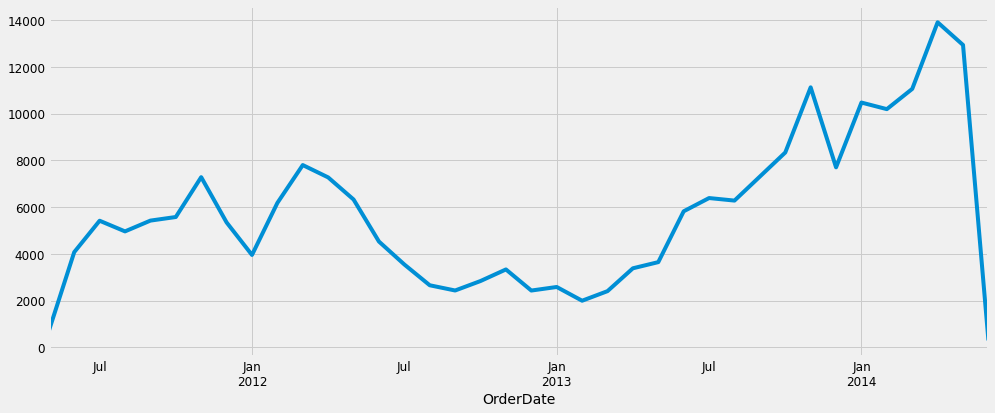

In [14]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

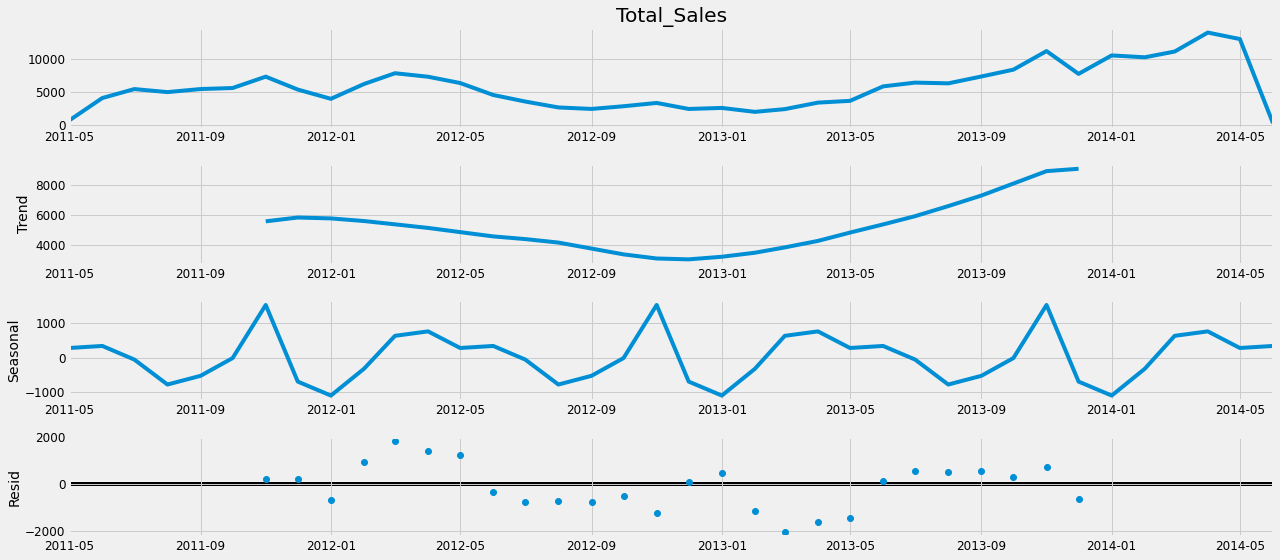

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [17]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:758.6585372421866
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1042.7472884796957
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:502.2662948759703
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:268.58853699308185
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:524.3276054898442
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1035.6743915720647
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:268.83481084589766
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:239.29300143953503
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:710.6230415882544
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2282.7347778590824
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:468.5758375252134
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:243.08255896380598
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:513.9538997204522
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2359.8801777364433
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:266.8149278533381
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:227.66528993232623
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:668.4910276032463
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:918.719298549855
AR

 ### Fitting an ARIMA Time Series Model

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8952      6.624     -0.135      0.892     -13.877      12.087
ma.L1          0.8673      8.742      0.099      0.921     -16.267      18.002
ar.S.L12      -1.5772      2.845     -0.554      0.579      -7.153       3.998
ma.S.L12      -1.1978      1.723     -0.695      0.487      -4.575       2.179
sigma2      1.294e+07   2.41e-07   5.36e+13      0.000    1.29e+07    1.29e+07


### Validating forecasts

In [20]:
#pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()


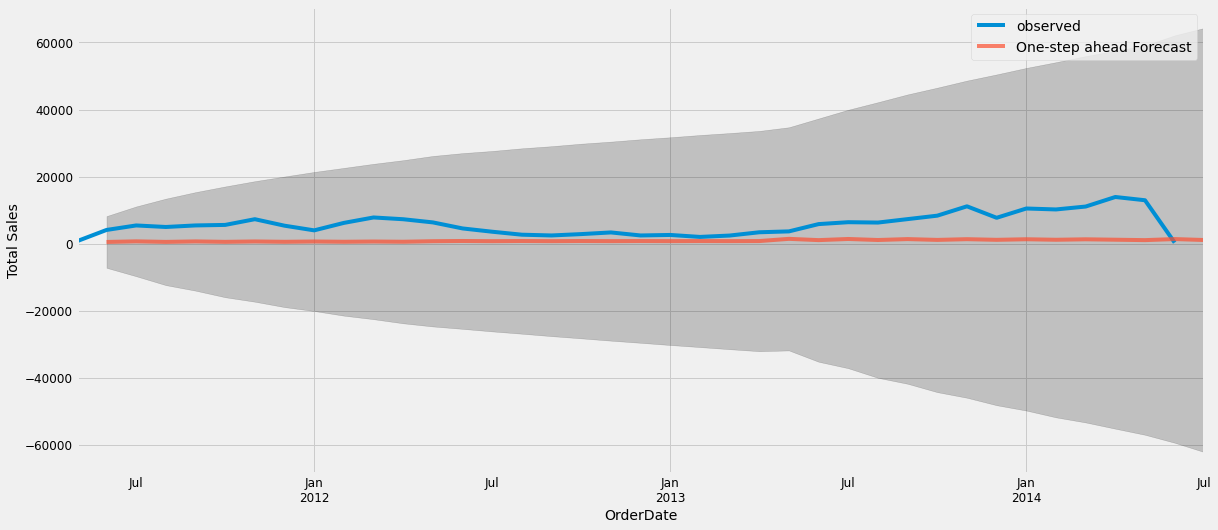

In [21]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()

plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 94391930.84


In [23]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 9715.55


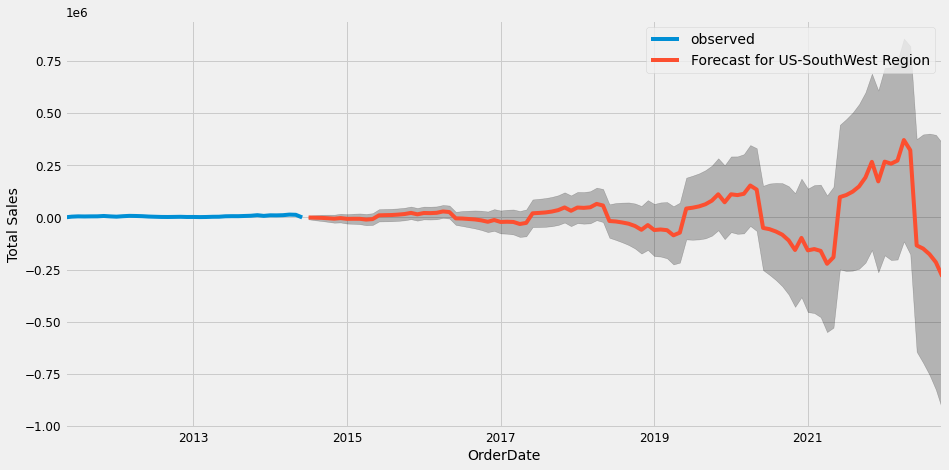

In [25]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast for US-SouthWest Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()